# MINIMUM EXACT COVER / Покрытие множеств минимальным объемом



In [1]:
import random
from IPython.core.display import SVG
import pyomo.environ as pyo
from pysat.solvers import Solver
from pysat.formula import CNF 
import py_svg_combinatorics as psc
from ipywidgets import widgets, HBox
from collections import Counter
from pprint import pprint
from random import randint
import numpy as np
from IPython.display import IFrame
import IPython
from copy import copy
import os
from pathlib import Path
nbname = ''
try:
    nbname = __vsc_ipynb_file__
except:
    if 'COCALC_JUPYTER_FILENAME' in os.environ:
        nbname = os.environ['COCALC_JUPYTER_FILENAME']    
title_ = Path(nbname).stem.replace('-', '_').title()    
IFrame(f'https://discopal.ispras.ru/index.php?title=Hardprob/{title_}&useskin=cleanmonobook', width=1280, height=300)

## Постановка задачи

Представим, что мы имеем конечное множество «U» (*universum*) и «S» — список подмножеств множества «U». 

*Покрытием* называют семейство $\mathcal{C}\subseteq\mathcal{S}$ наименьшей мощности, объединением которых является $\mathcal{U}$.
В случае постановки вопроса *о разрешении* на вход подаётся пара $(\mathcal{U},\mathcal{S})$ и целое число *k*; вопросом является существование покрывающего множества мощности *k* (или менее).

Оптимизационная версия задачи, '''минимальное покрытие множеств''', задаёт вопрос о минимальном объеме покрытия, измеряемого не в числе множеств из «S» покрывающих «U»,
а в числе элементов в этих подмножествах

* https://www.csc.kth.se/~viggo/wwwcompendium/node147.html
* https://en.wikipedia.org/wiki/Exact_cover



In [2]:
sets = [
        [f"{i:02}" for i in range(1,18)],
        [f"{2*i:02}" for i in range(1,10)]+['01'],
        [f"{i:02}" for i in np.random.choice(np.arange(1,20), 1)],
        [f"{i:02}" for i in np.random.choice(np.arange(1,20), 2)],
        [f"{i:02}" for i in np.random.choice(np.arange(1,20), 3)],
        [f"{i:02}" for i in np.random.choice(np.arange(1,20), 4)],
        [f"{i:02}" for i in np.random.choice(np.arange(1,20), 5)],
        [f"{i:02}" for i in np.random.choice(np.arange(1,20), 6)],
        [f"{i:02}" for i in np.random.choice(np.arange(1,20), 7)],
        [f"{i:02}" for i in np.random.choice(np.arange(1,20), 8)],
        [f"{i:02}" for i in np.random.choice(np.arange(1,20), 9)],
]


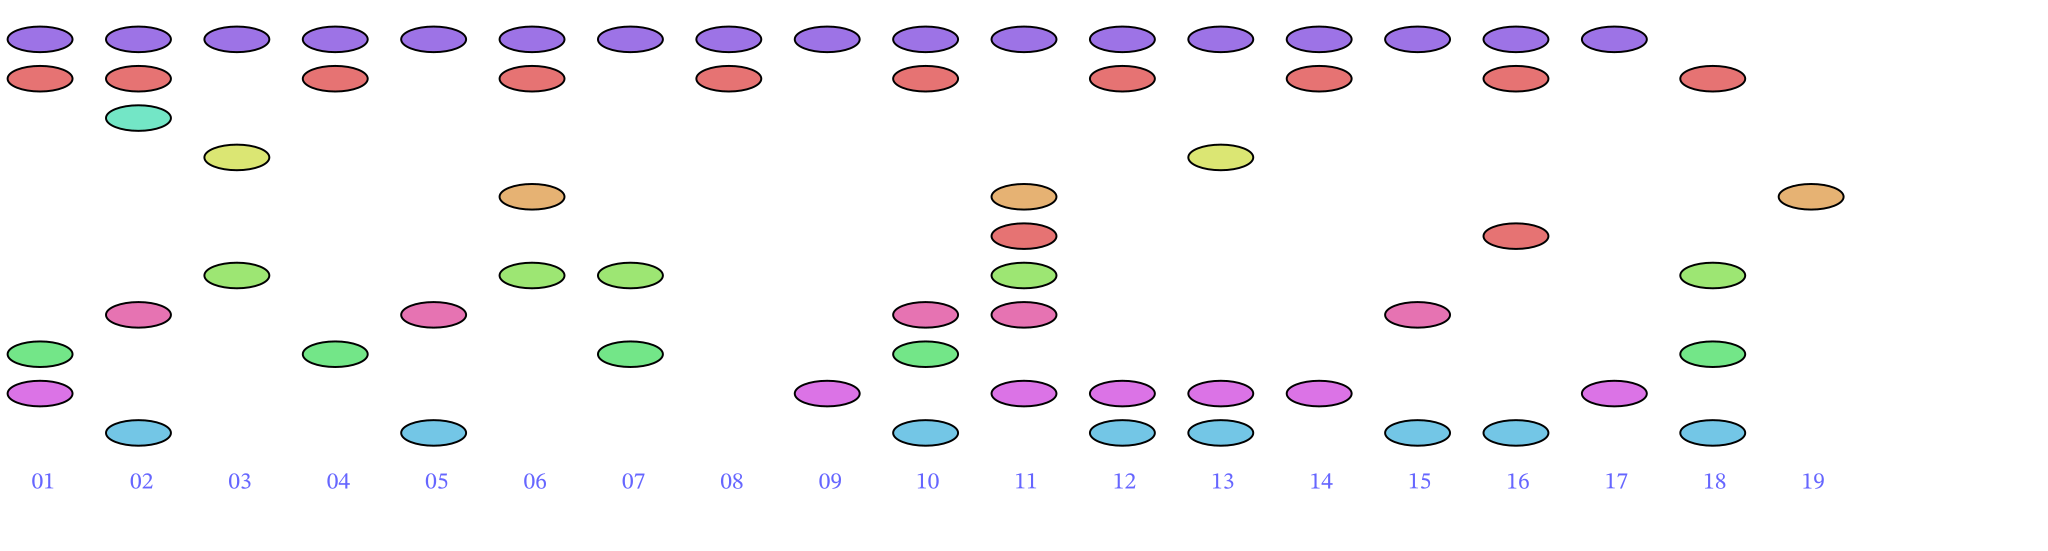

In [3]:
svg = psc.subsets2svg(sets)
SVG(data=svg)

## Реализация в Pyomo

In [4]:
def print_solution(m):
    for v in m.component_data_objects(pyo.Var):
        if v.value and v.value > 0:
            print(str(v), v.value)

In [41]:
def get_model(sets):
    sets_ = sets
    if isinstance(sets_, dict):
        sets_ = [val for _, val in sets_.items()]

    model = pyo.ConcreteModel()
    model.S = [set(str(item) for item in sublist) for sublist in sets_]
    model.m = len(model.S)
    model.J = range(model.m)
    model.U = sorted(set([str(item) for sublist in sets_ for item in sublist]))
    model.n = len(model.U)

    #Включаем ли это подмножество.
    model.x = pyo.Var(model.J, domain=pyo.Binary)
    model.set_count = pyo.Objective(expr = sum( len(model.S[j]) * model.x[j] for j in model.J), sense=pyo.minimize)

    @model.Constraint(model.U)
    def каждый_элемент_покрыт_хотябы_одним_множеством(m, u):
        return sum(m.x[j] for j in m.J if u in m.S[j]) >= 1

    return model


m = get_model(sets)
m.U


['C_{0}', 'C_{1}', 'G0', 'G1', 'G2', 'x_{1}', 'x_{2}', 'x_{3}']

In [42]:
m.S

[{'C_{0}', 'G1', 'x_{1}'},
 {'C_{1}', 'G1', 'x_{1}'},
 {'C_{0}', 'C_{1}', 'x_{2}'},
 {'G1', 'G2', 'x_{2}'},
 {'C_{0}', 'C_{1}', 'x_{3}'},
 {'G1', 'G2', 'x_{3}'},
 {'G0', 'G1', 'G2'}]

In [43]:
m.pprint()

2 Set Declarations
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    7 : {0, 1, 2, 3, 4, 5, 6}
    каждый_элемент_покрыт_хотябы_одним_множеством_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    8 : {'C_{0}', 'C_{1}', 'G0', 'G1', 'G2', 'x_{1}', 'x_{2}', 'x_{3}'}

1 Var Declarations
    x : Size=7, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    set_cou

In [44]:

ilp_solver = pyo.SolverFactory('cbc')
ilp_solver.solve(m).write()
print_solution(m)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 12.0
  Upper bound: 12.0
  Number of objectives: 1
  Number of constraints: 5
  Number of variables: 6
  Number of binary variables: 7
  Number of integer variables: 7
  Number of nonzeros: 6
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.02
  Wallclock time: 0.02
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
    

In [45]:
print_solution(m)

x[0] 1.0
x[3] 1.0
x[4] 1.0
x[6] 1.0


In [46]:
selected = [j for j in m.J if m.x[j].value > 0]
selected


[0, 3, 4, 6]

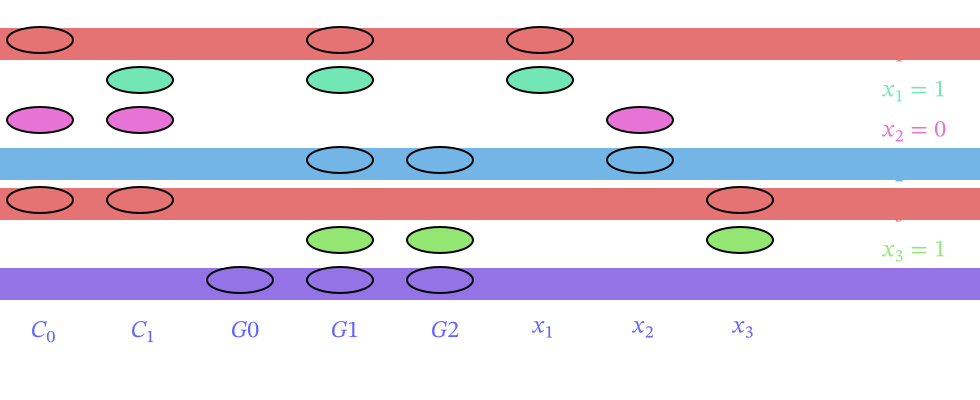

In [47]:
SVG(psc.subsets2svg(sets, selected))


In [11]:
cnf3 = CNF(from_clauses=psc.rand3cnf(1, 3))
cnf3.clauses


[(-3, 1, -2)]

In [12]:
from pysat.solvers import Solver

solver = Solver(bootstrap_with=cnf3)
res = solver.solve()
res 

True

In [13]:
print(solver.get_model())


[-1, -2, -3]


In [14]:
cnf3.clauses

[(-3, 1, -2)]

In [15]:
from collections import defaultdict
def cnf32setcovering(cnf):
    '''
    Будем считать, что на входе 3SAT формула без повторов литералов в дизьюнкциях и т.п.
    '''
    n = cnf.nv
    m = len(cnf.clauses)
    S = {}

    for j in range(1, n+1):
        S[f'x_{{{j}}}=0'] = [f'x_{{{j}}}']
        S[f'x_{{{j}}}=1'] = [f'x_{{{j}}}']

    for i in range(m):
        U_clause = f'''C_{{{i}}}'''
        clause = cnf.clauses[i]
        for lit in clause:
            j = abs(lit)
            needvar = f'x_{{{j}}}=1'
            if lit < 0:
                needvar = f'x_{{{j}}}=0'
            S[needvar].append(U_clause)
    # Набиваем мусором, чтобы выровнять множества по размеру        
    max_size = max([len(s) for s in S.values()])        
    max_garbage_items = 0
    for s in S:
        add_garbage_items = max_size - len(S[s])
        max_garbage_items = max(max_garbage_items, add_garbage_items)
        for i in range(add_garbage_items):        
            S[s].append(f'G{i+1}')
    S['G'] = [f'G{i}' for i in range(max_garbage_items+1)]
    return S


In [16]:
cnf3 = CNF(from_clauses=psc.rand3cnf(1, 3))
cnf3.clauses

[(-1, 3, -2)]

In [17]:
sets = cnf32setcovering(cnf3)
pprint(sets)

{'G': ['G0', 'G1'],
 'x_{1}=0': ['x_{1}', 'C_{0}'],
 'x_{1}=1': ['x_{1}', 'G1'],
 'x_{2}=0': ['x_{2}', 'C_{0}'],
 'x_{2}=1': ['x_{2}', 'G1'],
 'x_{3}=0': ['x_{3}', 'G1'],
 'x_{3}=1': ['x_{3}', 'C_{0}']}


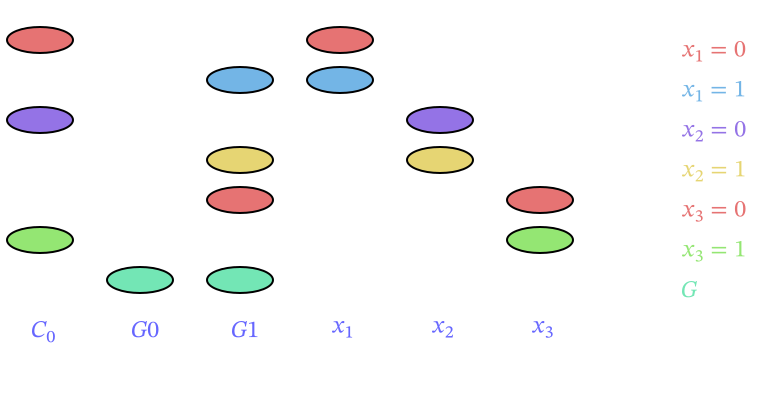

In [18]:
SVG(psc.subsets2svg(sets))

In [19]:
m = get_model(sets)
m.U, m.S


(['C_{0}', 'G0', 'G1', 'x_{1}', 'x_{2}', 'x_{3}'],
 [{'C_{0}', 'x_{1}'},
  {'G1', 'x_{1}'},
  {'C_{0}', 'x_{2}'},
  {'G1', 'x_{2}'},
  {'G1', 'x_{3}'},
  {'C_{0}', 'x_{3}'},
  {'G0', 'G1'}])

In [20]:
# ilp_solver = pyo.SolverFactory('cbc')
ilp_solver.solve(m).write()
print_solution(m)


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 8.0
  Upper bound: 8.0
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 6
  Number of binary variables: 7
  Number of integer variables: 7
  Number of nonzeros: 6
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.01
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      

In [21]:
m.x.extract_values()

{0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 1.0, 6: 1.0}

In [22]:
selected = [j for j in m.J if m.x.extract_values()[j] > 0]
selected


[1, 3, 5, 6]

In [23]:
cnf3.clauses

[(-1, 3, -2)]

In [24]:
pprint(sets)

{'G': ['G0', 'G1'],
 'x_{1}=0': ['x_{1}', 'C_{0}'],
 'x_{1}=1': ['x_{1}', 'G1'],
 'x_{2}=0': ['x_{2}', 'C_{0}'],
 'x_{2}=1': ['x_{2}', 'G1'],
 'x_{3}=0': ['x_{3}', 'G1'],
 'x_{3}=1': ['x_{3}', 'C_{0}']}


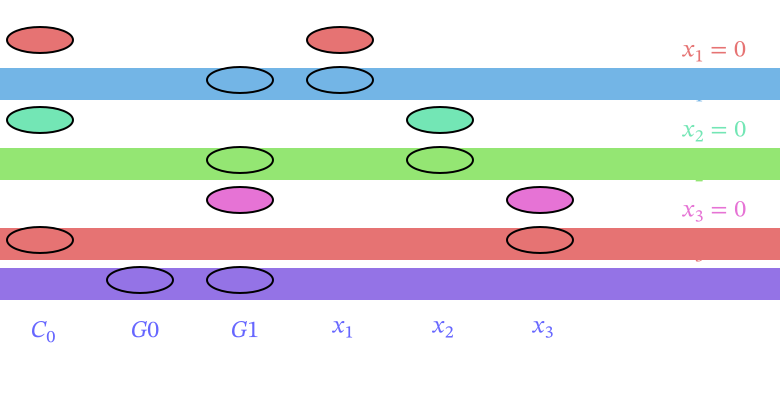

In [25]:
SVG(psc.subsets2svg(sets, selected))

In [26]:
cnf3 = CNF(from_clauses=psc.rand3cnf(2, 3))
cnf3.clauses

[(-2, -1, -3), (1, -2, -3)]

In [27]:
sets = cnf32setcovering(cnf3)
pprint(sets)

{'G': ['G0', 'G1', 'G2'],
 'x_{1}=0': ['x_{1}', 'C_{0}', 'G1'],
 'x_{1}=1': ['x_{1}', 'C_{1}', 'G1'],
 'x_{2}=0': ['x_{2}', 'C_{0}', 'C_{1}'],
 'x_{2}=1': ['x_{2}', 'G1', 'G2'],
 'x_{3}=0': ['x_{3}', 'C_{0}', 'C_{1}'],
 'x_{3}=1': ['x_{3}', 'G1', 'G2']}


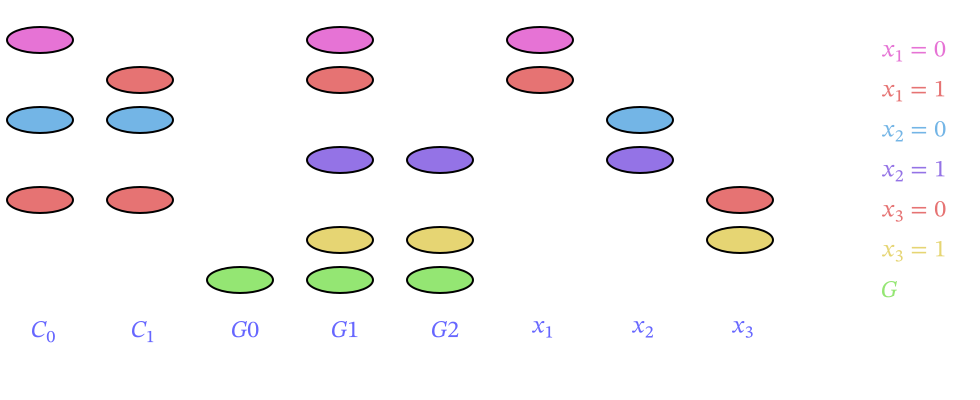

In [28]:
SVG(psc.subsets2svg(sets))

In [29]:
m = get_model(sets)
m.U, m.S


(['C_{0}', 'C_{1}', 'G0', 'G1', 'G2', 'x_{1}', 'x_{2}', 'x_{3}'],
 [{'C_{0}', 'G1', 'x_{1}'},
  {'C_{1}', 'G1', 'x_{1}'},
  {'C_{0}', 'C_{1}', 'x_{2}'},
  {'G1', 'G2', 'x_{2}'},
  {'C_{0}', 'C_{1}', 'x_{3}'},
  {'G1', 'G2', 'x_{3}'},
  {'G0', 'G1', 'G2'}])

In [30]:
ilp_solver.solve(m).write()
print_solution(m)


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 12.0
  Upper bound: 12.0
  Number of objectives: 1
  Number of constraints: 5
  Number of variables: 6
  Number of binary variables: 7
  Number of integer variables: 7
  Number of nonzeros: 6
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.01
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
    

In [31]:
selected = [j for j in m.J if m.x[j].value > 0]
selected


[0, 3, 4, 6]

In [32]:
cnf3.clauses

[(-2, -1, -3), (1, -2, -3)]

In [33]:
pprint(sets)

{'G': ['G0', 'G1', 'G2'],
 'x_{1}=0': ['x_{1}', 'C_{0}', 'G1'],
 'x_{1}=1': ['x_{1}', 'C_{1}', 'G1'],
 'x_{2}=0': ['x_{2}', 'C_{0}', 'C_{1}'],
 'x_{2}=1': ['x_{2}', 'G1', 'G2'],
 'x_{3}=0': ['x_{3}', 'C_{0}', 'C_{1}'],
 'x_{3}=1': ['x_{3}', 'G1', 'G2']}


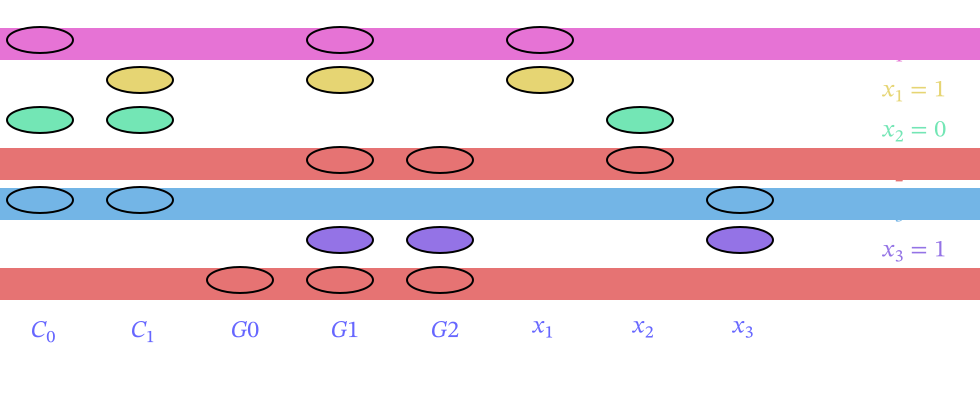

In [34]:
SVG(psc.subsets2svg(sets, selected))

In [35]:
m.pprint()
m.U


2 Set Declarations
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    7 : {0, 1, 2, 3, 4, 5, 6}
    каждый_элемент_покрыт_хотябы_одним_множеством_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    8 : {'C_{0}', 'C_{1}', 'G0', 'G1', 'G2', 'x_{1}', 'x_{2}', 'x_{3}'}

1 Var Declarations
    x : Size=7, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   1.0 :     1 : False : False : Binary
          1 :     0 :   0.0 :     1 : False : False : Binary
          2 :     0 :   0.0 :     1 : False : False : Binary
          3 :     0 :   1.0 :     1 : False : False : Binary
          4 :     0 :   1.0 :     1 : False : False : Binary
          5 :     0 :   0.0 :     1 : False : False : Binary
          6 :     0 :   1.0 :     1 : False : False : Binary

1 Objective Declarations
    set_cou

['C_{0}', 'C_{1}', 'G0', 'G1', 'G2', 'x_{1}', 'x_{2}', 'x_{3}']

# Генерация теcтов



In [37]:
def solution_of_ilp_to_3sat(m):
    ''' 
    Конвертируем ЦЛП-решение сведенной из 3SAT к MEC задачи, к вопросу, выполнима ли 3CNF-формула?
    '''
    res = sum(m.x.extract_values().values())-1 == (len(m.x)-1)/2
    return res

In [38]:
from pyomo.opt import SolverStatus, TerminationCondition

def generate_tests(clauses_amount):
    test_cnf3 = CNF(from_clauses=psc.rand3cnf(clauses_amount, 3))
    
    ilp_test_sets = cnf32setcovering(test_cnf3)
    ilp_test_model = get_model(ilp_test_sets)
    ilp_test_result_struct = ilp_solver.solve(ilp_test_model)
    ilp_test_result = solution_of_ilp_to_3sat(ilp_test_model)    
#     ilp_test_result = (ilp_test_result_struct.solver.status == SolverStatus.ok and ilp_test_result_struct.solver.termination_condition == TerminationCondition.optimal)
#     ilp_test_no_result = (ilp_test_result_struct.solver.termination_condition == TerminationCondition.infeasible)
    
    py3sat_test_solver = Solver(bootstrap_with=test_cnf3)
    py3sat_test_result = py3sat_test_solver.solve()
    
    if (py3sat_test_result != ilp_test_result):
#         print("For clauses amount = ", clauses_amount, "solutions found: for Pyomo: ", ilp_test_result, ", if it is infeasible: ", ilp_test_no_result, ", for 3-SAT: ", py3sat_test_result)
        print("Fail!", test_cnf3, py3sat_test_result, ilp_test_result)
        raise Exception('WTF!')
#         return False#, ilp_test_sets, ilp_test_model, py3sat_test_solver.get_model()
    else:
#         print("Both solutions are found for clauses amount = ", clauses_amount, ", result is: ", py3sat_test_result)
        return True#, ilp_test_sets, ilp_test_model, py3sat_test_solver.get_model()

In [39]:
#result, got_sets, ilp_model, py3sat_model = generate_tests(1)
for clauses_amount_index in range(2, 20):
    for _ in range(100):
        result, got_sets, ilp_model, py3sat_model = generate_tests(clauses_amount_index)

TypeError: cannot unpack non-iterable bool object

In [ ]:
#result_selected = [j for j in ilp_model.J if ilp_model.x[j].value > 0]
#print(result_selected)

[1, 3, 4, 5, 6]

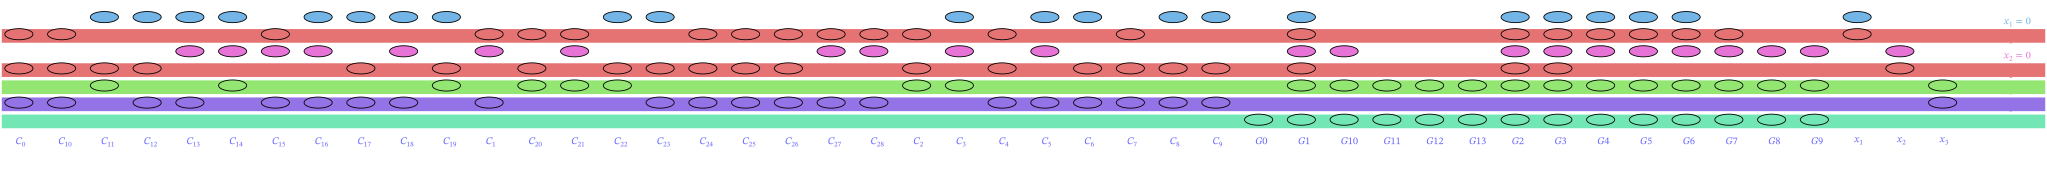

In [ ]:
#SVG(psc.subsets2svg(got_sets, result_selected))